In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import font_manager, rc
font_path= 'C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#### 통합 데이터 불러오기

In [3]:
df = pd.read_csv('../data_2/full형매변환.csv') 
print(df.shape)

df_copy = df.copy()

# 일단 농가 결측치는 제거
df_copy.dropna(subset=['농가근내평균'], inplace=True)
print(df_copy.shape)

# 형매 결측치 0채우기
print(df_copy.isna().sum())
df_copy.fillna(0, inplace=True)
print('=====')
print(f"결측치 총 개수:{df_copy.isna().sum(axis=1).sum()}")

(99848, 19)
(76307, 19)
개월령              0
생시체중             0
근내평균             0
도체범위근내평균         0
체고               0
체장               0
형매도축수        55263
형매도체평균       55263
형매근내평균       55263
형매근내평균가산     55263
출산여부_6개월내        0
농가근내평균           0
농가근내평균가산         0
근내EPD            0
근내               0
점수               0
농가구분             0
TARGET1          0
형매_bi        55263
dtype: int64
=====
결측치 총 개수:0


##### train_test_split 7:3

###### 결측치 채우고 난 후

In [4]:
print(f"체고 0 인거:{df_copy[df_copy['체고']==0]}")
print(len(df_copy))
df_copy.isna().sum()

체고 0 인거:Empty DataFrame
Columns: [개월령, 생시체중, 근내평균, 도체범위근내평균, 체고, 체장, 형매도축수, 형매도체평균, 형매근내평균, 형매근내평균가산, 출산여부_6개월내, 농가근내평균, 농가근내평균가산, 근내EPD, 근내, 점수, 농가구분, TARGET1, 형매_bi]
Index: []
76307


개월령          0
생시체중         0
근내평균         0
도체범위근내평균     0
체고           0
체장           0
형매도축수        0
형매도체평균       0
형매근내평균       0
형매근내평균가산     0
출산여부_6개월내    0
농가근내평균       0
농가근내평균가산     0
근내EPD        0
근내           0
점수           0
농가구분         0
TARGET1      0
형매_bi        0
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

X = df_copy.drop(['TARGET1'],axis=1)
Y = df_copy.TARGET1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 2023)

print(f'데이터 셋 70%:{df_copy.shape[0]*0.7}')
print(f'데이터 셋 30%:{df_copy.shape[0]*0.3}')

train = pd.concat([X_train,Y_train], axis=1)
test = pd.concat([X_test,Y_test], axis=1)

print(f'train set:{train.shape[0]}')
print(f'test set:{test.shape[0]}')

데이터 셋 70%:53414.899999999994
데이터 셋 30%:22892.1
train set:53414
test set:22893


In [6]:
model = sm.Logit.from_formula(""" TARGET1 ~ 근내평균 + 도체범위근내평균
                              + 형매근내평균가산+C(출산여부_6개월내)
+ 농가근내평균 + 농가근내평균가산 + 근내EPD
+C(농가구분) """, train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.337457
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                TARGET1   No. Observations:                53414
Model:                          Logit   Df Residuals:                    53405
Method:                           MLE   Df Model:                            8
Date:                Wed, 25 Oct 2023   Pseudo R-squ.:                  0.1803
Time:                        17:03:44   Log-Likelihood:                -18025.
converged:                       True   LL-Null:                       -21991.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.6196      0.159    -41.598      0.000      -6.931      -6.308
C(출산여부_6개월내)[T.Y]    -0.4054      0.029    -14.144      0.000      -0.462      -0.349
C(농가구분)[T.우시장소]       0.2297      0.053      4.295      0.000       0.125       0.334
근내평균                  0.0674      0.032      2.112      0.035       0.005       0.130
도체범위근내평균              0.8406      0.021     40.491      0.000       0.800       0.881
형매근내평균가산              0.2302      0.021     10.837      0.000       0.189       0.272
농가근내평균                0.0414      0.021      1.999      0.046       0.001       0.082
농가근내평균가산              0.4705      0.025     18.637      0.000       0.421       0.520
근내EPD                 0.6716      0.068      9.942      0.000       0.539       0.804
=====================================================================================
"""

In [7]:
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.001334,0.000977,0.001822
C(출산여부_6개월내)[T.Y],0.666729,0.630309,0.705254
C(농가구분)[T.우시장소],1.258190,1.132994,1.397219
근내평균,1.069670,1.004854,1.138668
도체범위근내평균,2.317672,2.225266,2.413916
형매근내평균가산,1.258913,1.207564,1.312447
농가근내평균,1.042245,1.000815,1.085391
농가근내평균가산,1.600757,1.523481,1.681953
근내EPD,1.957445,1.714688,2.234572


In [8]:
train_copy = train.copy()

pred_y_1 = model.predict(train)

train_copy['probability_tr'] = pred_y_1

print(len(train_copy))
train_copy.head()

53414


,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,출산여부_6개월내,농가근내평균,농가근내평균가산,근내EPD,근내,점수,농가구분,형매_bi,TARGET1,probability_tr
74658,51,632.14,2.50,2.40,131.1,152.9,0.0,0.00,0.0,0.00,Y,4.44,-0.50,-0.03,3,2,농가소,0,0,0.007312
47151,38,748.21,5.00,5.58,132.7,158.0,0.0,0.00,0.0,0.00,Y,5.67,-0.68,0.29,7,5,농가소,0,1,0.131428
65363,50,737.50,4.19,5.67,129.2,137.1,6.0,377.17,5.0,0.04,Y,5.31,1.13,-0.04,7,4,농가소,3마리이상,0,0.223905
73951,50,867.86,5.12,6.00,129.9,146.7,0.0,0.00,0.0,0.00,Y,5.84,0.48,0.42,8,5,농가소,0,1,0.291694
64019,54,671.43,4.51,4.72,128.1,147.4,0.0,0.00,0.0,0.00,Y,4.73,-0.57,0.06,3,2,농가소,0,0,0.058091


In [9]:
# train set 만들기
test_copy = test.copy()

pred_y = model.predict(test_copy)

test_copy['probability'] = pred_y

print(len(test_copy))
test_copy.head()

22893


,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,출산여부_6개월내,농가근내평균,농가근내평균가산,근내EPD,근내,점수,농가구분,형매_bi,TARGET1,probability
24682,58,692.86,4.16,4.54,131.3,154.1,0.0,0.0,0.0,0.00,N,4.67,0.28,0.08,6,4,농가소,0,0,0.104842
99156,48,695.00,5.22,5.33,128.6,149.9,0.0,0.0,0.0,0.00,N,5.67,0.49,0.34,8,5,우시장소,0,1,0.296374
29604,33,650.00,4.93,5.14,125.8,143.9,0.0,0.0,0.0,0.00,N,4.43,-0.62,0.23,6,4,농가소,0,0,0.127755
4970,44,825.00,4.89,5.82,134.9,157.6,0.0,0.0,0.0,0.00,Y,4.42,0.06,0.49,7,5,농가소,0,1,0.220406
98627,30,524.00,4.78,3.80,125.8,143.9,3.0,458.0,4.0,-1.81,Y,6.00,1.52,0.06,4,3,우시장소,3마리이상,0,0.063432


In [18]:
def performance(TP,TN,FP,FN,BETA):
    
    N = TP+TN+FP+FN
    
    Sensitivity=(TP/(TP+FN))*100
    Sensitivity_l=(Sensitivity/100-1.96*math.sqrt( (Sensitivity/100)*(1-(Sensitivity/100))/(TP+FN) ) )*100
    Sensitivity_u=(Sensitivity/100+1.96*math.sqrt( (Sensitivity/100)*(1-(Sensitivity/100))/(TP+FN) ) )*100

    Specificity=(1-FP/(TN+FP))*100
    Specificity_l=(Specificity/100-1.96*math.sqrt( (Specificity/100)*(1-(Specificity/100))/(FP+TN) ) )*100
    Specificity_u=(Specificity/100+1.96*math.sqrt( (Specificity/100)*(1-(Specificity/100))/(FP+TN) ) )*100

    Accuracy=((TP+TN)/(TP+TN+FP+FN))*100
    Accuracy_l=(Accuracy/100-1.96*math.sqrt( (Accuracy/100)*(1-(Accuracy/100))/N ) )*100
    Accuracy_u=(Accuracy/100+1.96*math.sqrt( (Accuracy/100)*(1-(Accuracy/100))/N ) )*100

    PPV= (TP/(TP+FP))*100 
    PPV_l=(PPV/100-1.96*math.sqrt( (PPV/100)*(1-(PPV/100))/(TP+FP) ) )*100
    PPV_u=(PPV/100+1.96*math.sqrt( (PPV/100)*(1-(PPV/100))/(TP+FP) ) )*100

    NPV= (TN/(TN+FN))*100 
    NPV_l=(NPV/100-1.96*math.sqrt( (NPV/100)*(1-(NPV/100))/(TN+FN) ) )*100
    NPV_u=(NPV/100+1.96*math.sqrt( (NPV/100)*(1-(NPV/100))/(TN+FN) ) )*100
    
    F_beta_score = (1+BETA**2)*((PPV*Sensitivity)/((PPV*BETA)+Sensitivity))
    
    result = {
        'Metric': ['Sensitivity', 'Specificity', 'Accuracy', 'PPV', 'NPV', f'F_{BETA}_score'],
        'Value': [Sensitivity, Specificity, Accuracy, PPV, NPV, F_beta_score],
        'CI_Lower': [Sensitivity_l, Specificity_l, Accuracy_l, PPV_l, NPV_l, None],
        'CI_Upper': [Sensitivity_u, Specificity_u, Accuracy_u, PPV_u, NPV_u, None]
    }
    
    result_2 = pd.DataFrame(result)
    
    return result_2

In [19]:
test_copy['prob_5'] = test_copy['probability'].apply(lambda x: 1 if 0.5<= x else 0 if 0<x<5 else x)
test_copy['prob_6'] = test_copy['probability'].apply(lambda x: 1 if 0.6<= x else 0 if 0<x<6 else x)
test_copy['prob_7'] = test_copy['probability'].apply(lambda x: 1 if 0.7<= x else 0 if 0<x<7 else x)
test_copy['prob_8'] = test_copy['probability'].apply(lambda x: 1 if 0.8<= x else 0 if 0<x<8 else x)
test_copy['prob_9'] = test_copy['probability'].apply(lambda x: 1 if 0.9<= x else 0 if 0<x<9 else x)

test_copy['prob_85'] = test_copy['probability'].apply(lambda x: 1 if 0.85<= x else 0 if 0<x<85 else x)

In [20]:
train_copy['prob_5'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.5<= x else 0 if 0<x<5 else x)
train_copy['prob_6'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.6<= x else 0 if 0<x<6 else x)
train_copy['prob_7'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.7<= x else 0 if 0<x<7 else x)
train_copy['prob_8'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.8<= x else 0 if 0<x<8 else x)
train_copy['prob_9'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.9<= x else 0 if 0<x<9 else x)

train_copy['prob_85'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.85<= x else 0 if 0<x<85 else x)


In [21]:
print(len(test_copy[test_copy['prob_5'].isnull()==False]))
print(len(test_copy[test_copy['prob_6'].isnull()==False]))
print(len(test_copy[test_copy['prob_7'].isnull()==False]))
print(len(test_copy[test_copy['prob_8'].isnull()==False]))
print(len(test_copy[test_copy['prob_9'].isnull()==False]))

22893
22893
22893
22893
22893


In [22]:
print(f"5이상개수:{len(test_copy[test_copy['점수']==5])}")
print(f"TARGET1개수:{len(test_copy[test_copy['TARGET1']==1])}")
print('========================================='*2)
print(f"0.5이상개수:{len(test_copy[test_copy['probability']>=0.5])}")
print(f"prob_5개수:{len(test_copy[test_copy['prob_5']==1])}")
print('========================================='*2)
print(f"0.6이상개수:{len(test_copy[test_copy['probability']>=0.6])}")
print(f"prob_6개수:{len(test_copy[test_copy['prob_6']==1])}")
print('========================================='*2)
print(f"0.7이상개수:{len(test_copy[test_copy['probability']>=0.7])}")
print(f"prob_7개수:{len(test_copy[test_copy['prob_7']==1])}")
print('========================================='*2)
print(f"0.8이상개수:{len(test_copy[test_copy['probability']>=0.8])}")
print(f"prob_8개수:{len(test_copy[test_copy['prob_8']==1])}")
print('========================================='*2)
print(f"0.9이상개수:{len(test_copy[test_copy['probability']>=0.9])}")
print(f"prob_9개수:{len(test_copy[test_copy['prob_9']==1])}")

5이상개수:3321
TARGET1개수:3321
0.5이상개수:835
prob_5개수:835
0.6이상개수:404
prob_6개수:404
0.7이상개수:143
prob_7개수:143
0.8이상개수:39
prob_8개수:39
0.9이상개수:7
prob_9개수:7


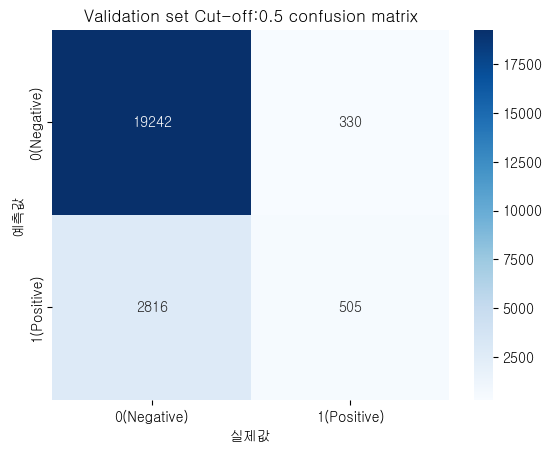

True Positive:505
True Negative:19242
False Positive:330
False Negative:2816


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,15.206263,13.984985,16.427542
1,Specificity,98.313918,98.133539,98.494297
2,Accuracy,86.257808,85.811811,86.703805
3,PPV,60.479042,57.162931,63.795153
4,NPV,87.233657,86.793256,87.674058
5,F_0.5_score,25.295532,NaN,NaN


In [23]:
# cut-off 0.5 validation set
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_5'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Validation set Cut-off:0.5 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

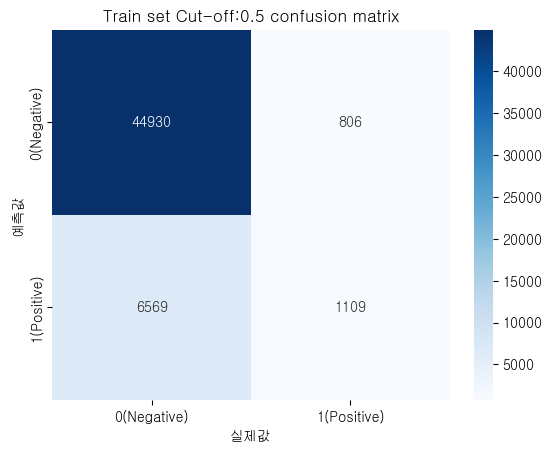

True Positive:1109
True Negative:44930
False Positive:806
False Negative:6569


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,14.443866,13.657546,15.230186
1,Specificity,98.237712,98.117124,98.358300
2,Accuracy,86.192758,85.900197,86.485320
3,PPV,57.911227,55.699986,60.122469
4,NPV,87.244413,86.956291,87.532534
5,F_0.5_score,24.091936,NaN,NaN


In [24]:
# cut-off 0.5 train set
cm = confusion_matrix(train_copy['TARGET1'],train_copy['prob_5'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Train set Cut-off:0.5 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==1)])}")
print(f"True Negative:{len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==0)])}")
print(f"False Positive:{len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==0)])}")
print(f"False Negative:{len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==1)])}")

performance(TP=len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==1)]),
            TN=len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==0)]),
            FP=len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==0)]),
            FN=len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==1)]),
            BETA=0.5)

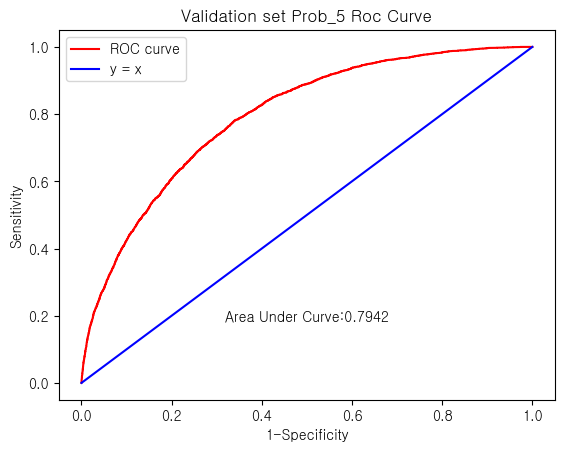

In [25]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(test_copy['TARGET1'], test_copy['probability'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(test_copy['TARGET1'], test_copy['probability'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Validation set Prob_5 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

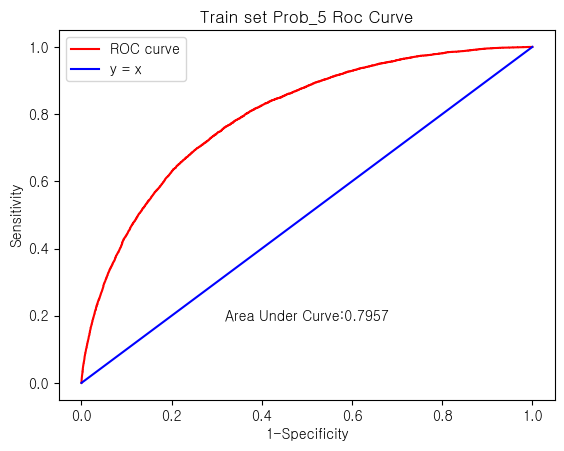

In [26]:
# roc curve, auc train set
fpr, tpr, thresholds = roc_curve(train_copy['TARGET1'], train_copy['probability_tr'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(train_copy['TARGET1'], train_copy['probability_tr'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Train set Prob_5 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

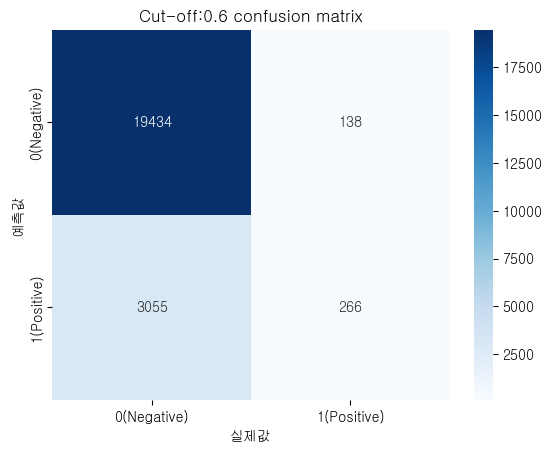

True Positive:266
True Negative:19434
False Positive:138
False Negative:3055


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,8.160193,7.229112,9.091273
1,Specificity,99.320458,99.205360,99.435555
2,Accuracy,86.096187,85.647995,86.544378
3,PPV,67.079208,62.496792,71.661624
4,NPV,86.437814,85.990320,86.885309
5,F_1_score,14.550336,NaN,NaN


In [27]:
# cut-off 0.6
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_6'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.6 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=271,TN=19439,FP=133,FN=3050,BETA=1)

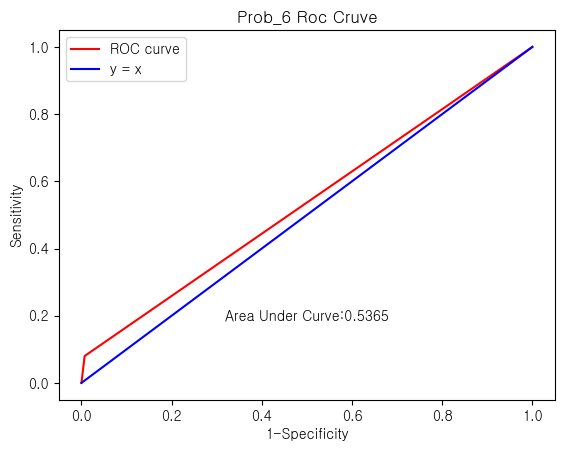

In [28]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(test_copy['TARGET1'], test_copy['prob_6'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(test_copy['TARGET1'], test_copy['prob_6'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_6 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

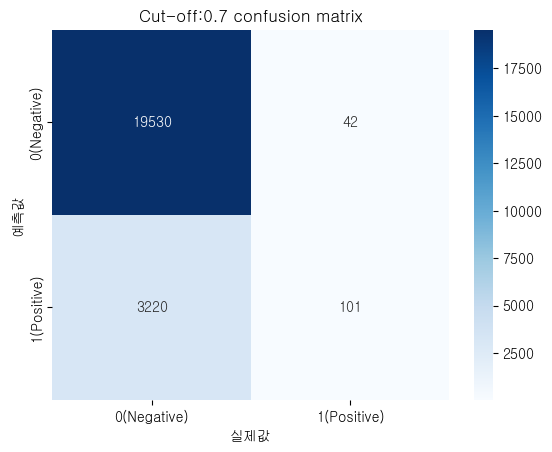

True Positive:101
True Negative:19530
False Positive:42
False Negative:3220


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,2.981030,2.402623,3.559436
1,Specificity,99.800736,99.738259,99.863213
2,Accuracy,85.755471,85.302720,86.208222
3,PPV,71.739130,64.226581,79.251680
4,NPV,85.840475,85.387485,86.293464
5,F_1_score,5.724198,NaN,NaN


In [29]:
# cut-off 0.7
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_7'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.7 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=99,TN=19533,FP=39,FN=3222,BETA=1)

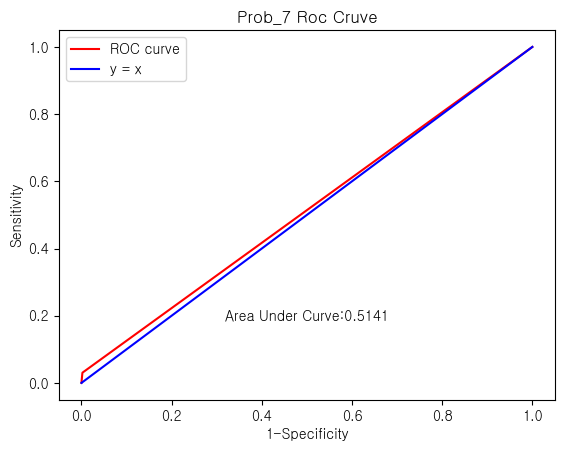

In [30]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(test_copy['TARGET1'], test_copy['prob_7'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(test_copy['TARGET1'], test_copy['prob_7'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_7 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

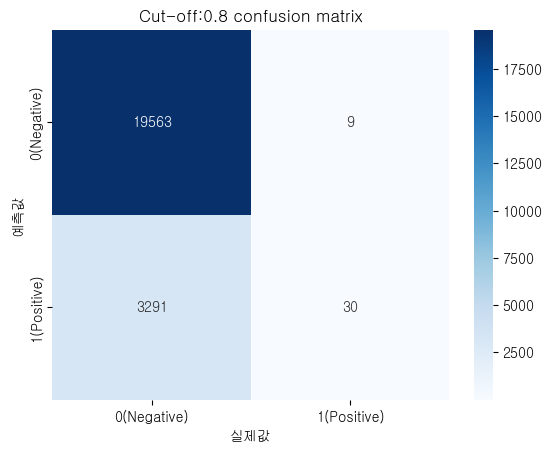

True Positive:30
True Negative:19563
False Positive:9
False Negative:3291


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,0.843120,0.532143,1.154096
1,Specificity,99.943797,99.910593,99.977002
2,Accuracy,85.567641,85.112414,86.022868
3,PPV,71.794872,57.671626,85.918118
4,NPV,85.591144,85.135837,86.046451
5,F_1_score,1.666667,NaN,NaN


In [31]:
# cut-off 0.8
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_8'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.8 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=28,TN=19561,FP=11,FN=3293,BETA=1)

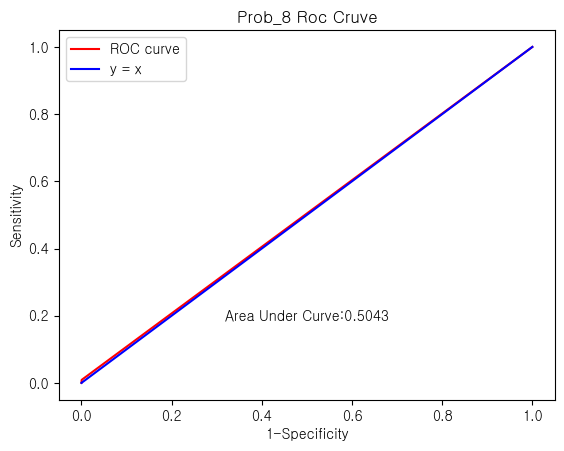

In [32]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(test_copy['TARGET1'], test_copy['prob_8'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(test_copy['TARGET1'], test_copy['prob_8'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_8 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

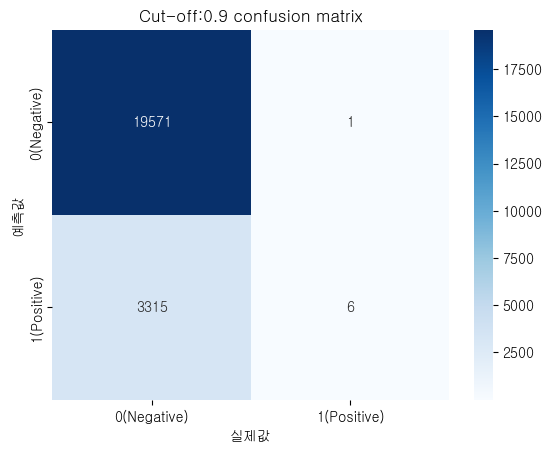

True Positive:6
True Negative:19571
False Positive:1
False Negative:3315


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,0.210780,0.054797,0.366763
1,Specificity,99.994891,99.984877,100.004905
2,Accuracy,85.519591,85.063735,85.975447
3,PPV,87.500000,64.582349,110.417651
4,NPV,85.518899,85.062954,85.974844
5,F_1_score,0.420547,NaN,NaN


In [33]:
# cut-off 0.9
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_9'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.9 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=7,TN=19571,FP=1,FN=3314,BETA=1)

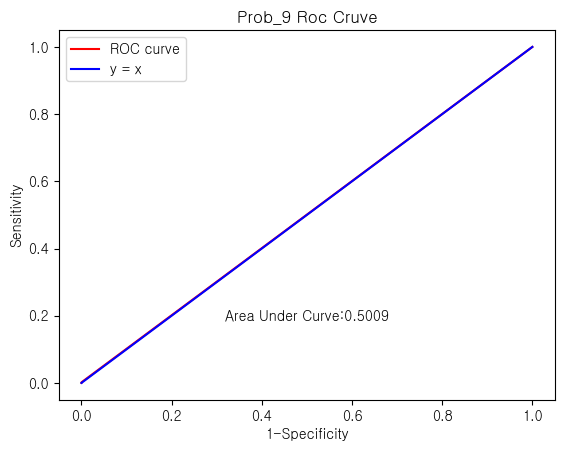

In [34]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(test_copy['TARGET1'], test_copy['prob_9'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(test_copy['TARGET1'], test_copy['prob_9'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_9 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

##### 0.85

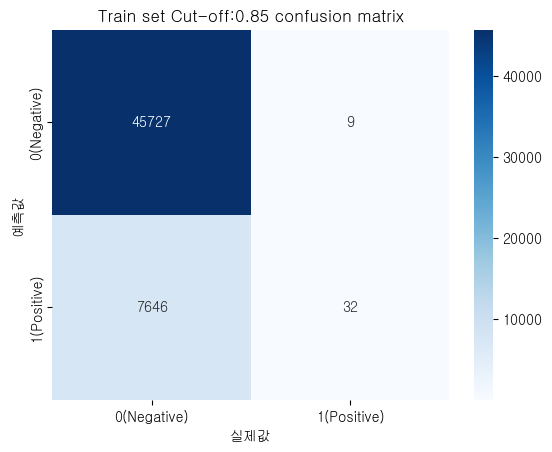

True Positive:32
True Negative:45727
False Positive:9
False Negative:7646


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,0.416775,0.272671,0.560879
1,Specificity,99.980322,99.967467,99.993177
2,Accuracy,85.668551,85.371395,85.965707
3,PPV,78.048780,65.378783,90.718778
4,NPV,85.674405,85.377185,85.971624
5,F_0.5_score,1.030928,NaN,NaN


In [35]:
# cut-off 0.85 train
cm = confusion_matrix(train_copy['TARGET1'], train_copy['prob_85'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Train set Cut-off:0.85 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==1)])}")
print(f"True Negative:{len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==0)])}")
print(f"False Positive:{len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==0)])}")
print(f"False Negative:{len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==1)])}")

performance(TP=len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==1)]),
            TN=len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==0)]),
            FP=len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==0)]),
            FN=len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==1)]),
            BETA=0.5)

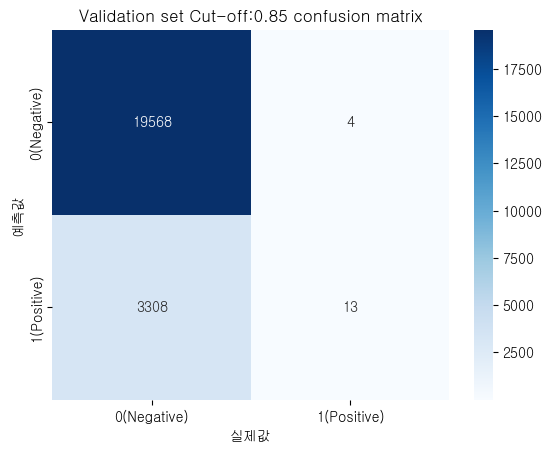

True Positive:13
True Negative:19568
False Positive:4
False Negative:3308


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,0.391448,0.179072,0.603825
1,Specificity,99.979563,99.959536,99.999589
2,Accuracy,85.532696,85.077011,85.988380
3,PPV,76.470588,56.306232,96.634944
4,NPV,85.539430,85.083664,85.995196
5,F_0.5_score,0.968703,NaN,NaN


In [36]:
# cut-off 0.85 validation
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_85'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Validation set Cut-off:0.85 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)